<a href="https://colab.research.google.com/github/gabrielqueeiroz/aps-poc/blob/main/notebooks/01-data-preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objetivo:** Limpar e preparar os dados.

**Conteúdo:**

*   Carregar o seu dataset sintético.
*   Realizar uma análise exploratória de dados (EDA) para entender a distribuição dos dados e identificar possíveis problemas.
* Descrever os passos para transformar os dados brutos em um formato adequado para o seu pipeline.
* Salvar o dataset pré-processado em um novo arquivo para uso nos próximos notebooks.

In [3]:
import pandas as pd
import requests
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from datetime import datetime, timedelta
import random
import json

In [4]:
LLAMA_SERVER_URL = "http://192.168.0.254:8080/completion"

In [5]:
df = pd.read_csv('../data/synthetic_dataset1.csv')
df.head()

,sexo,dataNascimento,localDeAtendimento,tipoAtendimento,vacinaEmDia,ficouEmObservacao,ciap_A03,ciap_D01,ciap_K01,ciap_L03,...,temperatura,pressaoArterialSistolica,pressaoArterialDiastolica,frequenciaCardiaca,frequenciaRespiratoria,saturacaoO2,peso,altura,glicemiaCapilar,especialidade_encaminhamento
0,0,836360599027,6,6,True,False,False,False,True,False,...,36.4,151,75,74,19,100,95.54,189.1,174,6
1,1,600977208247,9,2,False,True,False,False,False,False,...,38.1,156,78,89,20,95,83.81,185.1,144,45
2,0,9868181892,8,4,False,True,False,True,False,False,...,38.2,124,100,62,14,90,72.89,170.7,104,18
3,0,935157448414,5,6,False,True,False,False,False,True,...,36.1,126,85,65,14,97,54.12,157.4,142,37
4,0,746467983761,4,4,False,True,False,True,False,False,...,38.3,134,65,60,13,94,79.75,175.7,140,18


In [6]:
# ciap_idx = df.columns.get_loc('ciap')

# unique_ciap = df['ciap'].unique()

# ciap_dummies = pd.get_dummies(df['ciap'], prefix='ciap')

# df = df.drop(columns=['ciap'])

# for i, col in enumerate(ciap_dummies.columns):
#     df.insert(ciap_idx + i, col, ciap_dummies[col])

# df.head()

In [7]:
patient_report = "Sinto um cansaço extremo e uma dor no peito que aparece quando faço esforço. Não tenho febre, mas estou preocupado com esses sintomas."

In [8]:
prompt_template = f"""
Você é um assistente de triagem médica. Sua tarefa é extrair os sintomas de um relato de paciente e listá-los com seus códigos CIAP-2 correspondentes, usando a lista de referência abaixo.

### Lista de Referência CIAP-2:
[
  {{
    \"codigo_ciap2\": \"A03\",
    \"descricao_ciap2\": \"FEBRE\",
    \"sintoma\": \"febre\"
  }},
  {{
    \"codigo_ciap2\": \"A04\",
    \"descricao_ciap2\": \"DEBILIDADE/CANSAÇO GERAL/FADIGA\",
    \"sintoma\": \"cansaço\"
  }},
  {{
    \"codigo_ciap2\": \"D01\",
    \"descricao_ciap2\": \"DOR ABDOMINAL GENERALIZADA/CÓLICAS\",
    \"sintoma\": \"dor abdominal\"
  }},
  {{
    \"codigo_ciap2\": \"D11\",
    \"descricao_ciap2\": \"DIARREIA\",
    \"sintoma\": \"diarreia\"
  }},
  {{
    \"codigo_ciap2\": \"N01\",
    \"descricao_ciap2\": \"CEFALÉIA\",
    \"sintoma\": \"dor de cabeça\"
  }},
  {{
    \"codigo_ciap2\": \"R05\",
    \"descricao_ciap2\": \"TOSSE\",
    \"sintoma\": \"tosse\"
  }},
  {{
    \"codigo_ciap2\": \"K01\",
    \"descricao_ciap2\": \"DOR ATRIBUÍDA AO CORAÇÃO\",
    \"sintoma\": \"dor no peito\"
  }},
  {{
    \"codigo_ciap2\": \"L03\",
    \"descricao_ciap2\": \"SINAIS/SINTOMAS DA REGIÃO LOMBAR\",
    \"sintoma\": \"dor nas costas\"
  }}
]

### Relato do paciente:
Estou com dor de cabeça e febre.

### Sintomas e códigos CIAP-2:
- dor de cabeça: N01
- febre: A03

### Relato do paciente:
{patient_report}

### Sintomas e códigos CIAP-2:
"""

In [9]:
payload = {
    "prompt": prompt_template,
    "n_predict": 128,
    "temperature": 0.7,
    "stream": False,
    "stop": ["\n### Relato do paciente:"]
}

In [10]:
try:
    print(f"Enviando requisição ao servidor Llama no IP: {LLAMA_SERVER_URL.split('/')[2]}")
    response = requests.post(LLAMA_SERVER_URL, json=payload, timeout=180)
    response.raise_for_status()
    
    result = response.json()
    
    content = result.get("content", "")
    print("\n--- Conteúdo da resposta do Llama-Server ---")
    print(content.strip())
    
except requests.exceptions.RequestException as e:
    print(f"\nERRO: Falha ao se comunicar com o servidor Llama: {e}")
except json.JSONDecodeError:
    print("\nERRO: Não foi possível decodificar a resposta JSON.")

Enviando requisição ao servidor Llama no IP: 192.168.0.254:8080

ERRO: Falha ao se comunicar com o servidor Llama: HTTPConnectionPool(host='192.168.0.254', port=8080): Max retries exceeded with url: /completion (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f3e7adf10>: Failed to establish a new connection: [Errno 111] Connection refused'))


In [11]:
class_mapping = {
    6: "CARDIOLOGIA",
    45: "PNEUMOLOGIA",
    18: "GASTROENTEROLOGIA",
    37: "ORTOPEDIA",
    31: "NEUROLOGIA",
    19: "CLINICA GERAL"
}

df['especialidade_encaminhamento'] = df['especialidade_encaminhamento'].map(class_mapping)
class_names = [class_mapping[label] for label in sorted(class_mapping.keys())]


Matriz de Confusão do Fold 1:


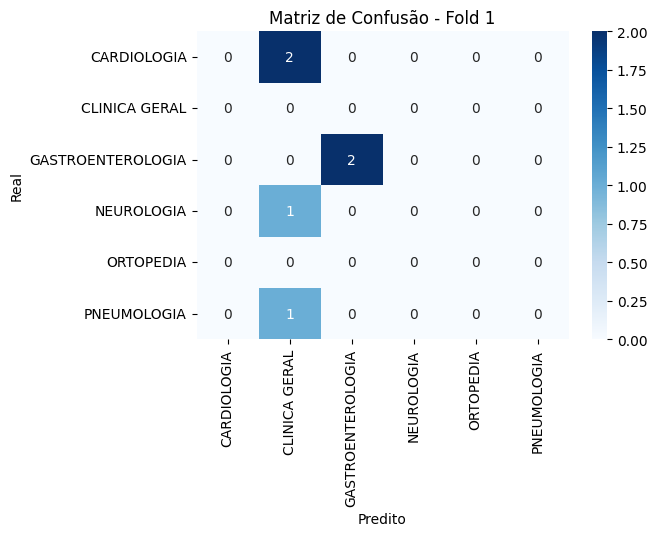


Matriz de Confusão do Fold 2:


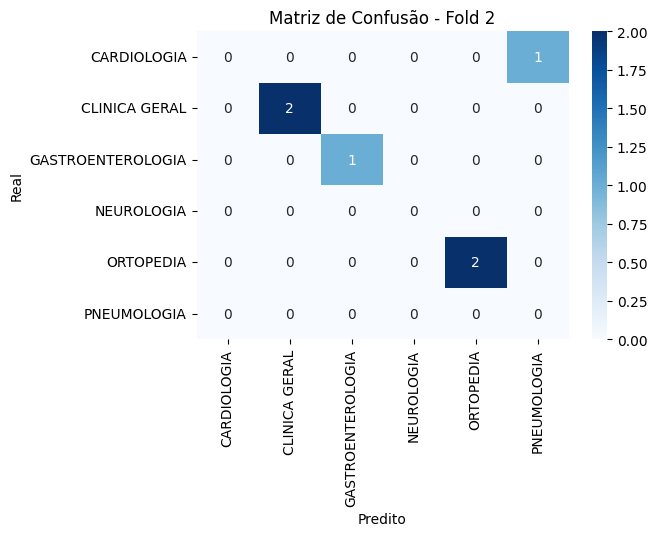


Matriz de Confusão do Fold 3:


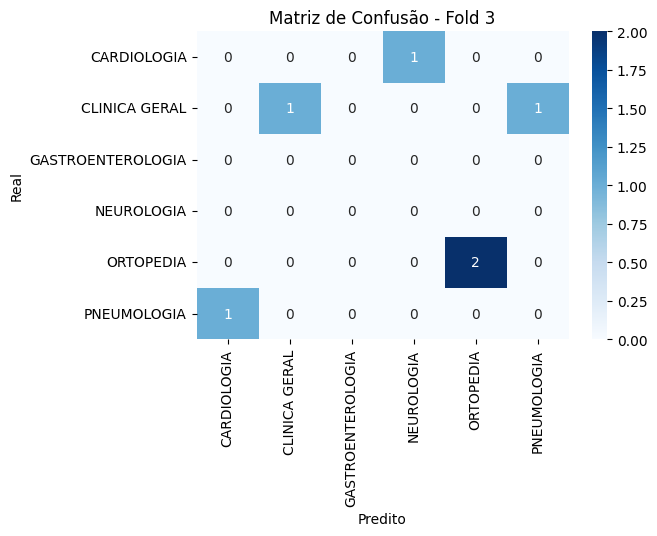


Matriz de Confusão do Fold 4:


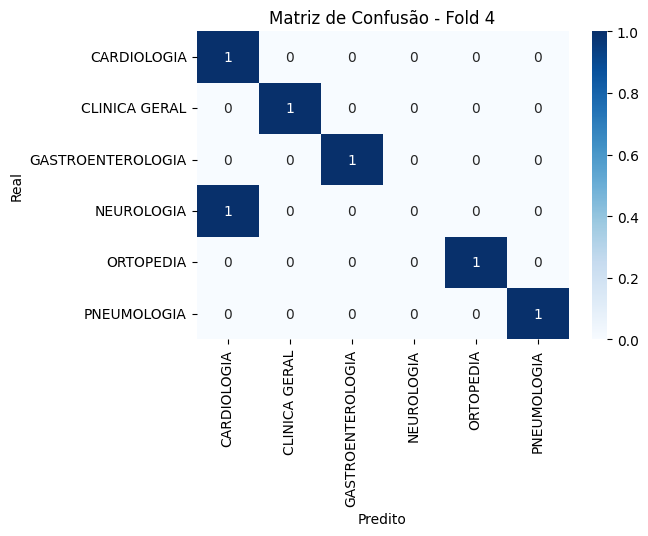


Matriz de Confusão do Fold 5:


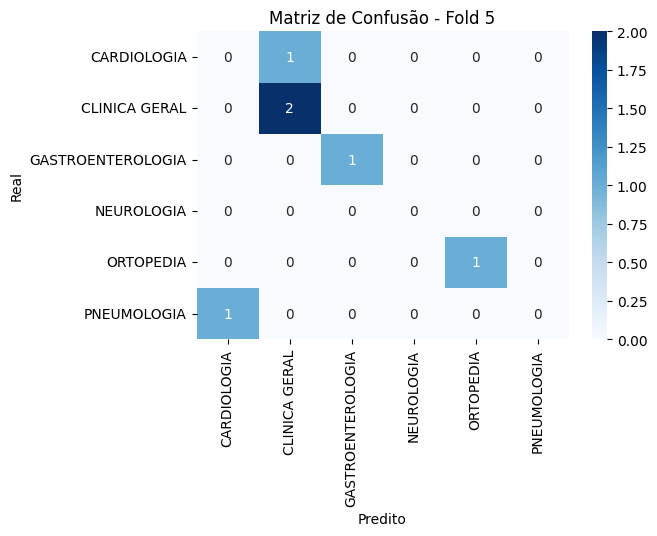

--- RandomForestClassifier ---
Acurácia Média: 0.633
F1 Score Médio: 0.494
Recall Médio: 0.507
Precisão Média: 0.497

Matriz de Confusão Agregada:


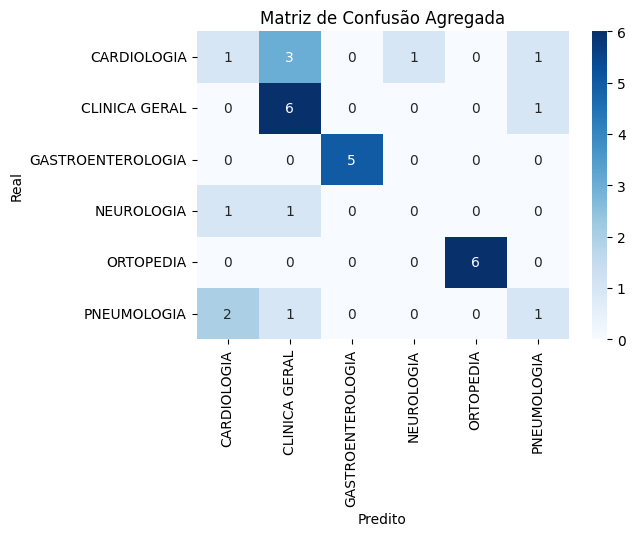

In [12]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=5)
model = RandomForestClassifier(random_state=42)

acc_score = []
f1_score_ = []
recall_score_ = []
precision_score_ = []
confusion_matrices = []

all_labels = sorted(y.unique())

for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    pred_values = model.predict(X_test)

    acc_score.append(accuracy_score(y_test, pred_values))
    f1_score_.append(f1_score(y_test, pred_values, average='macro', zero_division=0))
    recall_score_.append(recall_score(y_test, pred_values, average='macro', zero_division=0))
    precision_score_.append(precision_score(y_test, pred_values, average='macro', zero_division=0))
    
    confusion_matrices.append(confusion_matrix(y_test, pred_values, labels=all_labels))

    print(f"\nMatriz de Confusão do Fold {fold + 1}:")
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrices[-1], annot=True, fmt='d', cmap='Blues',
                xticklabels=all_labels, yticklabels=all_labels)
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusão - Fold {fold + 1}')
    plt.show()

avg_acc_score = sum(acc_score) / k
avg_f1_score = sum(f1_score_) / k
avg_recall_score = sum(recall_score_) / k
avg_precision_score = sum(precision_score_) / k

print('--- RandomForestClassifier ---')
print(f'Acurácia Média: {avg_acc_score:.3f}')
print(f'F1 Score Médio: {avg_f1_score:.3f}')
print(f'Recall Médio: {avg_recall_score:.3f}')
print(f'Precisão Média: {avg_precision_score:.3f}')

aggregated_cm = np.sum(confusion_matrices, axis=0)
print("\nMatriz de Confusão Agregada:")
plt.figure(figsize=(6, 4))
sns.heatmap(aggregated_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=all_labels, yticklabels=all_labels)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão Agregada')
plt.show()

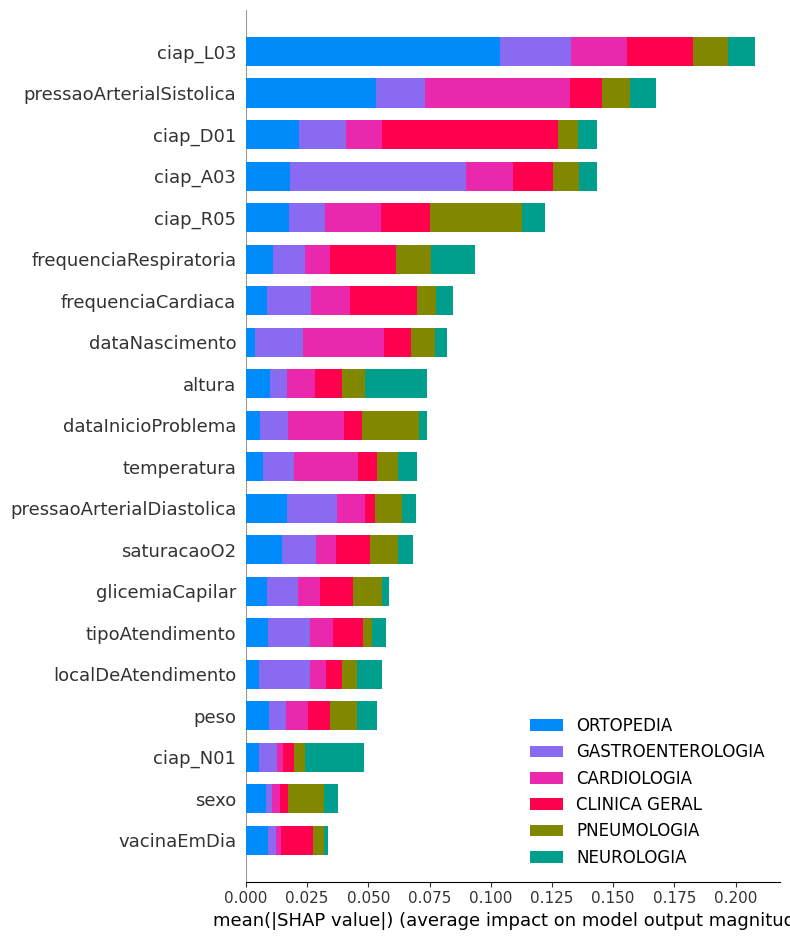

In [13]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)
shap.summary_plot(shap_values, X, class_names=class_names)

In [28]:
shap.force_plot(shap_values[1][0])

AttributeError: 'int' object has no attribute 'shape'

In [30]:
print(X.dtypes)

sexo                           int64
dataNascimento                 int64
localDeAtendimento             int64
tipoAtendimento                int64
vacinaEmDia                     bool
ficouEmObservacao               bool
ciap_A03                        bool
ciap_D01                        bool
ciap_K01                        bool
ciap_L03                        bool
ciap_N01                        bool
ciap_R05                        bool
ciap_A04                        bool
ciap_D11                        bool
dataInicioProblema             int64
temperatura                  float64
pressaoArterialSistolica       int64
pressaoArterialDiastolica      int64
frequenciaCardiaca             int64
frequenciaRespiratoria         int64
saturacaoO2                    int64
peso                         float64
altura                       float64
glicemiaCapilar                int64
dtype: object


In [19]:
explainer.expected_value

array([0.20583333, 0.20625   , 0.17125   , 0.08541667, 0.20958333,
       0.12166667])

In [20]:
y.unique()

array(['CARDIOLOGIA', 'PNEUMOLOGIA', 'GASTROENTEROLOGIA', 'ORTOPEDIA',
       'NEUROLOGIA', 'CLINICA GERAL'], dtype=object)

In [29]:
shap_values[1][0]

.values =
array([-0.00428899, -0.00108653, -0.00353428, -0.00394092, -0.00683064,
        0.01968136])

.base_values =
array([0.20583333, 0.20625   , 0.17125   , 0.08541667, 0.20958333,
       0.12166667])

.data =
1